In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import json
import os
# from bmtool.util.util import load_nodes_from_paths
from scipy.ndimage import gaussian_filter

import analysis.pipelines.population_spikes as ps
from analysis import plot, utils, process, metric # importing analysis module enables import from model folder
# from build_input import get_populations, input_pairs_from_file

%matplotlib inline

RESULT_PATH = "simulation_results"
OUTPUT_PATH = "analysis_results"
overwrite = False

pop_color = plot.pop_color
pop_names = plot.pop_names

In [2]:
ps.set_variables(RESULT_PATH=RESULT_PATH, OUTPUT_PATH=OUTPUT_PATH)

PN_pop_names = ps.PN_pop_names
ITN_pop_names = ps.ITN_pop_names

In [3]:
# General setting
fs = 400.  # Hz. sampling frequency
significant_duration = True  # whether select durations with significant wave amplitude
only_ramp = True  # whether get windows of only ramp durations for non-standard stimulus types
win_extend = 0.2  # extend window by xx sec after stimulus off

# Target populations to get waves
pop_wave = {**dict(zip(ITN_pop_names, ITN_pop_names)), **ps.pop_groups}
# pop_wave = ITN_pop_names  # only ITN subtypes

# Parameters for selecting significant durations of wave amplitude
wave_pop = {'gamma': 'FSI', 'beta': 'LTS'}
# wave_pop = {'gamma': 'ITN', 'beta': 'ITN'}
fr_indicator = True  # whether use ITN firing rate or wave amplitude as indicator
filt_sigma = 20.0  # firing rate Gaussian filer sigma (ms)
normalize_baseline = True  # whether normalize indicator by baseline, otherwise by trial average
baseline_fr = [7.5, 5.0]  # baseline firing rate
baseline_amp = [1.3868426, 0.56402801]  # baseline wave amplitude
choose_dominating = False  # whether select duration by single winner wave, otherwise by threshold crossing
threshold = {'gamma': 0.8, 'beta': 1.2}  # threshold on indicator for selecting significant duration
sigdur_kwargs = dict(wave_pop=wave_pop, fr_indicator=fr_indicator,
    filt_sigma=filt_sigma, normalize_baseline=normalize_baseline,
    baseline_amp=baseline_amp, baseline_fr=baseline_fr,
    choose_dominating=choose_dominating, threshold=threshold
)

# Wave parameters
method = 'wavelet'
wave_lines = {'gamma': ':', 'beta': '--'}
wave_color = {'gamma': 'tab:red', 'beta': 'tab:purple'}
waves = list(wave_lines)

wave_kwargs = {
    'filter': dict(
        waves = {'gamma': (30.0, 44.0), 'beta': (14.5, 23.5)},
        transform = process.wave_hilbert,
        filt_order = 4
    ),
    'wavelet': dict(
        waves = {'gamma': 37.0, 'beta': 19.0},
        transform = process.wave_cwt,
        bandwidth = 1.0  # time band (inverse to frequency band), sigma of the gaussian envelope for frequency 1.0
    )
}
wave_kwargs = wave_kwargs[method]
wave_kwargs['waves'] = {w: wave_kwargs['waves'][w] for w in waves}

In [4]:
filter = ()
revert_junction = False
exclude = ['baseline']

with open(os.path.join(OUTPUT_PATH, 'trials_ordered.json'), 'r') as f:
    trials_ordered = json.load(f)
trials = ps.get_trials(filter, trials=trials_ordered, revert_junction=revert_junction, exclude=exclude)
print(pd.Series(trials))

0                 short_rand
1                  short_div
2                  long_rand
3                   long_div
4          ramp_a0_t0.3_rand
5           ramp_a0_t0.3_div
6          ramp_a0_t1.0_rand
7           ramp_a0_t1.0_div
8     ramp_a0_t1.0_down_rand
9      ramp_a0_t1.0_down_div
10         ramp_a0_t3.0_rand
11          ramp_a0_t3.0_div
12         join_a0_t0.3_rand
13          join_a0_t0.3_div
14         join_a0_t1.0_rand
15          join_a0_t1.0_div
16    join_a0_t1.0_quit_rand
17     join_a0_t1.0_quit_div
18         join_a0_t3.0_rand
19          join_a0_t3.0_div
20        fade_a01_t0.1_rand
21         fade_a01_t0.1_div
22         fade_a03_t0.1_div
23        fade_a01_t0.3_rand
24         fade_a01_t0.3_div
25         fade_a03_t0.3_div
26        fade_a01_t1.0_rand
27         fade_a01_t1.0_div
28         fade_a03_t1.0_div
29        fade_a01_t3.0_rand
30         fade_a01_t3.0_div
31         fade_a03_t3.0_div
dtype: object


## Analyze all tirals and save results

In [5]:
durations = {}
for trial_name in trials:
    _, durations[trial_name], kwargs = ps.get_plv_population_wave(trial_name, wave_kwargs,
        fs=fs, pop_wave=pop_wave, only_ramp=only_ramp, win_extend=win_extend,
        significant_duration=significant_duration, sigdur_kwargs=sigdur_kwargs)

short_rand
gamma durations: 0 - 100 %
beta durations: 7 - 88 %
short_div
gamma durations: 0 - 100 %
beta durations: 7 - 88 %
long_rand
gamma durations: 0 - 19 %
beta durations: 8 - 86 %
long_div
gamma durations: 0 - 18 %
beta durations: 8 - 86 %
ramp_a0_t0.3_rand
gamma durations: 0 - 58 %, 82 - 100 %
beta durations: 36 - 68 %
ramp_a0_t0.3_div
gamma durations: 0 - 58 %, 82 - 100 %
beta durations: 36 - 68 %
ramp_a0_t1.0_rand
gamma durations: 0 - 51 %
beta durations: 31 - 87 %
ramp_a0_t1.0_div
gamma durations: 0 - 51 %
beta durations: 31 - 86 %
ramp_a0_t1.0_down_rand
gamma durations: 80 - 100 %
beta durations: 0 - 70 %
ramp_a0_t1.0_down_div
gamma durations: 80 - 100 %
beta durations: 0 - 70 %
ramp_a0_t3.0_rand
gamma durations: 0 - 41 %
beta durations: 22 - 23 %, 25 - 95 %
ramp_a0_t3.0_div
gamma durations: 0 - 42 %
beta durations: 25 - 95 %
join_a0_t0.3_rand
gamma durations: 0 - 47 %, 87 - 100 %
beta durations: 18 - 68 %
join_a0_t0.3_div
gamma durations: 0 - 46 %, 86 - 100 %
beta durations

In [6]:
param_file = os.path.join(ps.FR_ENTR_PATH, 'params' + ('_sigdur' if significant_duration else '') + '.json')
kwargs['wave_kwargs'] = kwargs['wave_kwargs'].copy()
kwargs['wave_kwargs']['transform'] = kwargs['wave_kwargs']['transform'].__name__
if not significant_duration:
    del kwargs['sigdur_kwargs']
with open(param_file, 'w') as f:
    json.dump(kwargs, f, indent=2)

In [11]:
if significant_duration:
    for dur in durations.values():
        for w, ds in dur.items():
            dur[w] = [list(d) for d in ds]
    duration_file = os.path.join(ps.FR_ENTR_PATH, 'significant_durations.json')
    with open(duration_file, 'w') as f:
        json.dump(durations, f, indent=2)

## Analyze single tiral

In [13]:
trial_name = trials[20]

# Get trial info and spike data
pop_ids, spikes_df, t_start, t_stop, trial_info = ps.load_trial(trial_name, pop_names)

isbaseline, isstandard = trial_info[0][1], trial_info[0][2]
INPUT_PATH = trial_info[1][0]
stim_setting, stim_params = trial_info[2][1], trial_info[2][2]

# Get windows of stimulus cycles
windows, (on_time, off_time, t_start, t_stop) = ps.get_stim_windows(stim_params,
    t_stop=t_stop, win_extend=win_extend, isbaseline=isbaseline, only_ramp=only_ramp)
t_cycle = 1000 * (on_time + off_time)

In [14]:
# Get population firing rate
time = np.linspace(0, 1000 * t_stop, int(t_stop * fs), endpoint=False)
pop_rspk = process.group_spike_rate_to_xarray(spikes_df, time,
    {k: pop_ids[p] for k, p in pop_wave.items() if not isinstance(p, list)}, group_dims='population')

# Get composed populations
comp_rspk = []
for k, pops in pop_wave.items():
    if isinstance(pops, list):
        if all([p in pop_rspk.population for p in pops]):
            # combine to get composed population
            comp_rspk.append(process.combine_spike_rate(pop_rspk, dim='population')\
                .expand_dims(dim={'population': [k]}))
        else:
            comp_rspk.append(process.group_spike_rate_to_xarray(spikes_df, time,
                {k: np.sort(np.concatenate([pop_ids[p] for p in pops]))}, group_dims='population'))
pop_rspk = xr.concat([pop_rspk] + comp_rspk, dim='population')

pop_waves = process.get_waves(pop_rspk.spike_rate, fs=pop_rspk.fs, component='both',
                              **wave_kwargs).rename(population='wave_population')

# display(pop_rspk)
display(pop_waves)

<xarray.DataArray 'wave_both' (component: 2, wave: 2, wave_population: 4, time: 8800)>
array([[[[ 1.49653389,  1.71411744,  1.91976838, ...,  3.36295776,
           3.23391924,  3.20577631],
         [ 0.29989858,  0.31576771,  0.43026438, ...,  1.67489687,
           1.63760753,  1.58817371],
         [ 0.04623328,  0.0446302 ,  0.06067212, ...,  0.50074759,
           0.50037721,  0.49701838],
         [ 0.81879049,  0.95135377,  1.05449658, ...,  2.68241392,
           2.59038111,  2.55416031]],

        [[ 2.36457105,  2.37628488,  2.40995822, ...,  1.63238945,
           1.58185043,  1.55323161],
         [ 0.97052914,  0.99640514,  1.01042281, ...,  1.26001412,
           1.28698915,  1.22724957],
         [ 0.60181744,  0.60681138,  0.61288879, ...,  0.39562187,
           0.39367352,  0.40400335],
         [ 1.61560767,  1.63822744,  1.66820687, ...,  1.43420856,
           1.42314892,  1.38301946]]],


       [[[-0.75949656, -0.21180199,  0.3406564 , ..., -0.36508934,
           0.22838401,  0.80617964],
         [ 1.58302305,  2.06534842,  2.57577091, ..., -0.2195935 ,
           0.37152728,  0.94464872],
         [ 2.09507387,  2.24458412,  2.46530616, ...,  0.26245477,
           0.81718916,  1.36243155],
         [-0.65429882, -0.11063024,  0.46951506, ..., -0.32887051,
           0.26446572,  0.8405164 ]],

        [[ 2.77299274,  3.06123516, -2.92998896, ...,  1.02272051,
           1.30715995,  1.57086438],
         [-2.35689494, -2.09897513, -1.82858604, ...,  0.47653367,
           0.81135565,  1.0715071 ],
         [-2.36306193, -2.07185419, -1.7881159 , ...,  0.68250675,
           0.92902664,  1.23430379],
         [ 2.99444741, -3.00085469, -2.71219776, ...,  0.83915372,
           1.13420987,  1.4000643 ]]]])
Coordinates:
  * wave_population  (wave_population) <U3 'FSI' 'LTS' 'PN' 'ITN'
  * time             (time) float64 1.25 3.75 6.25 ... 2.199e+04 2.2e+04 2.2e+04
  * wave             (wave) object 'gamma' 'beta'
  * component        (component) object 'amp' 'pha'

### Choose duration of waves

In [15]:
wave_pop = {w: wave_pop[w] for w in waves}
sigma = filt_sigma * fs / 1000

# ITN firing rate wave amplitude
wave_amp = xr.concat([pop_waves.sel(wave=w, wave_population=p, component='amp') \
    for w, p in wave_pop.items()], dim='wave')
if fr_indicator:
    # ITN firing rate
    rspk_filt = xr.DataArray([gaussian_filter(pop_rspk.spike_rate.sel(population=p), sigma) \
        for p in wave_pop.values()], coords={'wave': waves, 'time': pop_rspk.time})
    # Get wave amplitude indicator
    wave_indicator = rspk_filt.copy()
else:
    wave_indicator = wave_amp.copy()

if normalize_baseline:
    baseline_norm_factor = baseline_fr if fr_indicator else baseline_amp
    wave_indicator /= xr.DataArray(baseline_norm_factor, coords={'wave': waves})
else:
    wave_indicator /= wave_indicator.sel(time=slice(1000 * t_start, None)).mean(dim='time')

#### Significant duration over whole trial

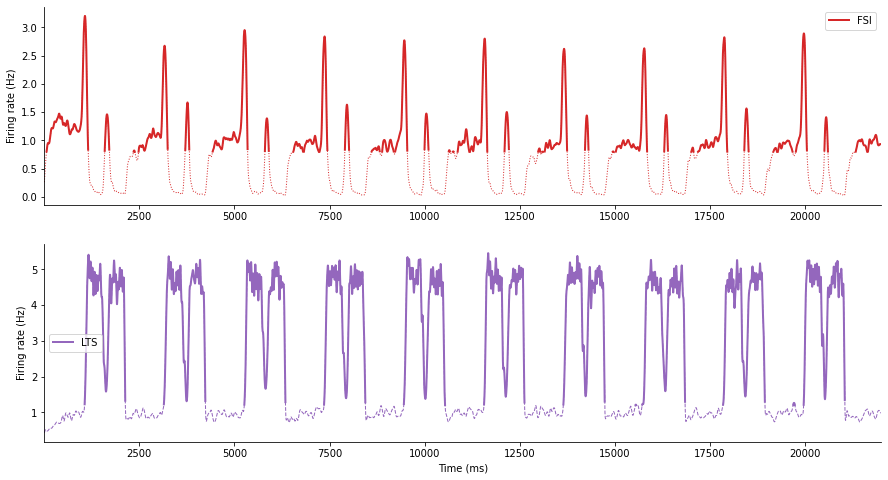

In [16]:
if choose_dominating:
    # Dominating wave
    main_wave = wave_indicator.argmax(dim='wave')
    wave_seg = {w: process.ind2seg(main_wave == i) for i, w in enumerate(waves)}
else:
    # Significant wave
    wave_seg = {w: process.ind2seg(wave_indicator.sel(wave=w).values > threshold[w]) for w in waves}

# time of segment edges
seg_time = {w: np.take(wave_amp.time.values, wave_seg[w] - np.array([0, 1])) - 1000 * t_start for w in waves}
seg_time = {w: np.mod(x[x[:, 0] > 0], t_cycle) for w, x in seg_time.items()}
for w, x in seg_time.items():
    x[x[:, 0] >= x[:, 1], 1] += t_cycle

# Significant duration over whole trial
figsize = (15, 4) if choose_dominating else (15, 8)
plt.figure(figsize=figsize)
for i, w in enumerate(waves):
    if not choose_dominating:
        plt.subplot(2, 1, i + 1)
    segs = wave_seg[w]
    amp = wave_indicator.sel(wave=w)
    label = wave_pop[w] if fr_indicator else w
    plt.plot(amp.time, amp.values, color=wave_color[w], linestyle=wave_lines[w], linewidth=1)
    for i0, i1 in segs:
        plt.plot(amp.time[i0:i1], amp.values[i0:i1], color=wave_color[w], linewidth=2, label=label)
        label = None
    plt.xlim(amp.time[[0, -1]])
    plt.ylabel('Firing rate (Hz)' if fr_indicator else 'Amplitude (Hz)')
    if len(segs):
        plt.legend()
plt.xlabel('Time (ms)')
plt.show()

#### Significant duration over averaged stimulus cycle

In [17]:
wave_indicator_avg = process.windowed_xarray(wave_indicator, windows, new_coord_name='cycle').mean(dim='cycle')

if choose_dominating:
    # Dominating wave
    main_wave = wave_indicator_avg.argmax(dim='wave')
    wave_seg = {w: process.ind2seg(main_wave==i) for i, w in enumerate(waves)}
else:
    # Significant wave
    wave_seg = {w: process.ind2seg(wave_indicator_avg.sel(wave=w).values > threshold[w]) for w in waves}

print(trial_name)
for w, segs in wave_seg.items():
    dur = 100 * segs / wave_indicator_avg.time.size
    print(w + ' durations: ' + ', '.join([f'{d0:.0f} - {d1:.0f} %' for d0, d1 in dur]))

fade_a01_t0.1_rand
gamma durations: 33 - 70 %
beta durations: 0 - 100 %


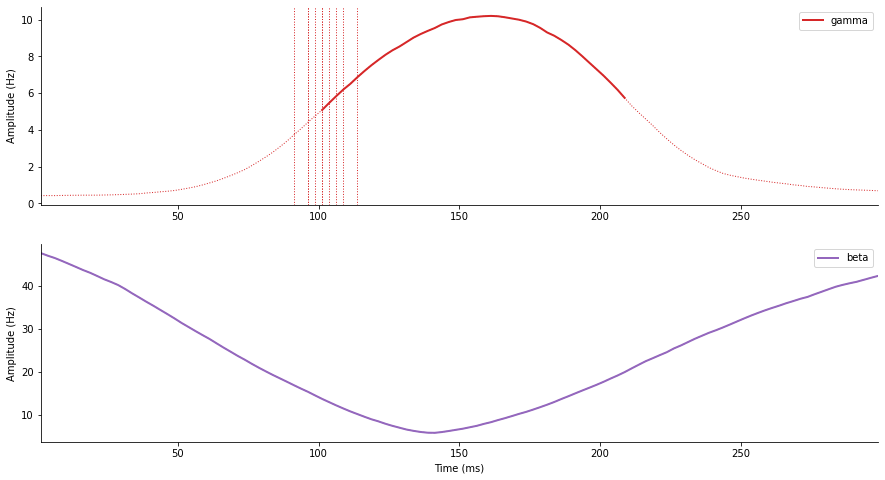

In [18]:
wave_amp_avg = process.windowed_xarray(wave_amp, windows, new_coord_name='cycle').mean(dim='cycle')

figsize = (15, 8)
plt.figure(figsize=figsize)
for i, w in enumerate(waves):
    plt.subplot(2, 1, i + 1)
    segs = wave_seg[w]
    amp = wave_amp_avg.sel(wave=w)
    label = w
    plt.plot(amp.time, amp.values, color=wave_color[w], linestyle=wave_lines[w], linewidth=1)
    for i0, i1 in segs:
        plt.plot(amp.time[i0:i1], amp[i0:i1].values, color=wave_color[w], linewidth=2, label=label)
        label = None
    for t in seg_time[w][:, 0]:
        plt.axvline(t, color=wave_color[w], linestyle=wave_lines[w],  linewidth=1)
    plt.xlim(amp.time[[0, -1]])
    plt.ylabel('Amplitude (Hz)')
    if len(segs):
        plt.legend()
plt.xlabel('Time (ms)')
plt.show()

In [19]:
# # Population groups for PLV (PN assemblies, FSI, LTS)
# assy_ids = utils.get_assemblies(INPUT_PATH, isstandard=isstandard,
#     stim_setting=stim_setting, distinguish_assy=False)[0]
# PN_names = xr.DataArray([f'PN_{a:d}' for a in assy_ids], coords={'assy_id': list(assy_ids)})
# grp_ids = {**dict(zip(PN_names.values, assy_ids.values())), **{p: pop_ids[p] for p in ITN_pop_names}}
# grp_ids = {p: xr.DataArray(ids, dims=p + '_units') for p, ids in grp_ids.items()}
# unit_ids = np.sort(np.concatenate([np.asarray(ids, dtype=int) for ids in grp_ids.values()]))

# # Calculate PLV
# pop_pha = pop_waves.sel(component='pha')
# if significant_duration:
#     axis = pop_pha.isel(wave=0).dims.index('time')
#     pop_plv = []
#     for w in pop_pha.wave.values:
#         seg_wins = np.array([pop_pha.time[[i0, i1]] for i0, i1 in wave_seg[w]])
#         seg_wins = np.reshape(windows[:, 0].reshape(-1, 1, 1) + seg_wins, (-1, 2))
#         tspk = process.get_windowed_spikes(spikes_df, seg_wins, unit_ids)
#         pop_plv.append(metric.phase_locking_value(process.get_spike_phase(
#             pop_pha.sel(wave=w), pop_pha.time, tspk, axis=axis)))
#     pop_plv = np.stack(pop_plv, axis=pop_pha.dims.index('wave') + 1)
# else:
#     axis = pop_pha.dims.index('time')
#     tspk = process.get_windowed_spikes(spikes_df, windows, unit_ids)
#     pop_plv = metric.phase_locking_value(process.get_spike_phase(pop_pha, pop_pha.time, tspk, axis=axis))

# # Save PLV results
# pop_plv = xr.DataArray(pop_plv, coords=dict(
#     unit_id=unit_ids, **{k: pop_pha.coords[k] for k in pop_pha.dims if k != 'time'}))
# plv_ds = xr.Dataset({'PLV': pop_plv, 'PN_names': PN_names, **grp_ids})

# file = trial_name + ('_sigdur' if significant_duration else '') + '.nc'
# # plv_ds.to_netcdf(os.path.join(ps.FR_ENTR_PATH, file))

### Mutual information between waves

In [20]:
# sliding time window parameters
win_size = int(6 * sigma) // 2 * 2 + 1
step_size = int(sigma)

# mutual information target waves
wave_true, wave_pred = 'beta', 'gamma'
w_true, w_pred = waves.index(wave_true), waves.index(wave_pred)

# wave amplitude and phase bins
nbins_amp = 16
nbins_pha = 16

quantiles = np.linspace(0, 1, nbins_amp + 1)
pha_bins = np.linspace(-np.pi, np.pi, nbins_pha + 1)
bin_label = pd.MultiIndex.from_product([range(nbins_amp),  range(nbins_pha)])
bin_label = pd.Series(range(bin_label.size), index=bin_label)

In [21]:
# get amp/pha classes
axis = wave_amp.dims.index('time')
amp_bins = np.moveaxis(np.quantile(wave_amp.sel(time=slice(1000 * t_start, None)).values,
                                   quantiles, axis=axis), 0, axis)
amp_bins = xr.DataArray(amp_bins, coords={'wave': wave_amp.wave, 'quantile': quantiles})

wave_pha = xr.concat([pop_waves.sel(wave=w, wave_population=p, component='pha') \
    for w, p in wave_pop.items()], dim='wave')

wave_amp_cls = np.array([np.digitize(wave_amp.sel(wave=w), amp_bins.sel(wave=w)[1:-1]) for w in waves])
wave_pha_cls = np.digitize(wave_pha, pha_bins[1:-1])
wave_amppha_cls = np.stack([wave_amp_cls, wave_pha_cls], axis=-1)
wave_amppha_cls = bin_label.loc[list(wave_amppha_cls.reshape(-1, 2))].values.reshape(wave_amppha_cls.shape[:-1])

# get sliding time windows
wins = np.arange(0, wave_amp.coords['time'].size - win_size + 1, step_size)
t_wins = wave_amp.time[wins + win_size // 2]
wins = np.column_stack([wins, wins + win_size])

In [22]:
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
from scipy.interpolate import interp1d

wave_nmi = [normalized_mutual_info_score(wave_amppha_cls[w_true, i:j], wave_amppha_cls[w_pred, i:j]) for i, j in wins]
wave_nmi = interp1d(t_wins, wave_nmi, assume_sorted=True, bounds_error=False, fill_value=(wave_nmi[0], wave_nmi[-1]))(wave_amp.time)
wave_nmi = xr.DataArray(wave_nmi, coords={'time': wave_amp.time})

wave_nmi_avg = process.windowed_xarray(wave_nmi, windows, new_coord_name='cycle').mean(dim='cycle')

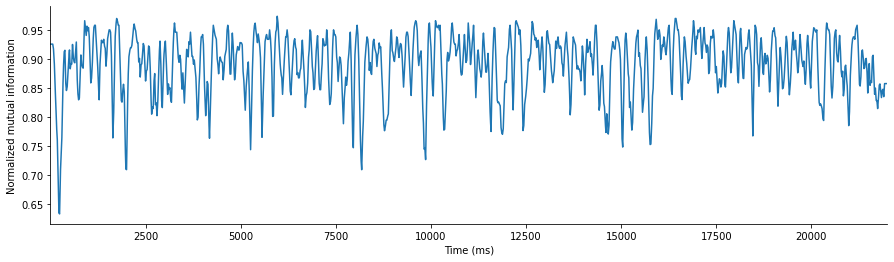

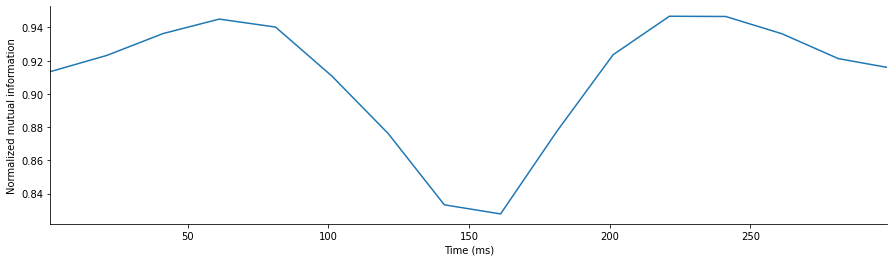

In [23]:
figsize = (15, 4)
plt.figure(figsize=figsize)
plt.plot(wave_nmi.time, wave_nmi.values)
plt.xlim(wave_nmi.time[[0, -1]])
plt.ylabel('Normalized mutual information')
plt.xlabel('Time (ms)')

figsize = (15, 4)
plt.figure(figsize=figsize)
plt.plot(wave_nmi_avg.time, wave_nmi_avg.values)
plt.xlim(wave_nmi_avg.time[[0, -1]])
plt.ylabel('Normalized mutual information')
plt.xlabel('Time (ms)')

plt.show()

In [24]:
# # baseline mutual information
# wave_nmi_avg.mean() - 3 * wave_nmi_avg.std()  # mean=0.93383629, std=0.02425357, -2 zs=0.88532915, -3 zs=0.86107558